In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_labels']
    valid_dataset = save['valid_data']
    valid_labels = save['valid_labels']
    test_dataset = save['test_data']
    test_labels = save['test_labels']
    test_filenames = save['test_filenames']
    del save  # hint to help gc free up memory
    
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (73392, 32, 32, 1) (73392, 5)
Validation set (9964, 32, 32, 1) (9964, 5)
Test set (13066, 32, 32, 1) (13066, 5)


In [3]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [4]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [5]:
image_size = 32
num_labels = 11 # 10 + invalid
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
shape=[batch_size, image_size, image_size, num_channels]

# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 11
# Output layer, weight size: 16 x 10

train_size = train_labels.shape[0]

graph = tf.Graph()
with graph.as_default():

    # Input data placeholders.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')
    
    layer4_weights_d1 = tf.get_variable("W4d1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer4_biases_d1 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d1')

    layer4_weights_d2 = tf.get_variable("W4d2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer4_biases_d2 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d2')
    
    layer4_weights_d3 = tf.get_variable("W4d3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer4_biases_d3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d3')

    layer4_weights_d4 = tf.get_variable("W4d4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    layer4_biases_d4 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d4')
    
    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        #print(reshape.get_shape())
        
        logits1 = tf.matmul(reshape, layer4_weights_d1) + layer4_biases_d1
        logits2 = tf.matmul(reshape, layer4_weights_d2) + layer4_biases_d2
        logits3 = tf.matmul(reshape, layer4_weights_d3) + layer4_biases_d3
        logits4 = tf.matmul(reshape, layer4_weights_d4) + layer4_biases_d4
        
        return [logits1, logits2, logits3, logits4]
    
    # Training computation.
    [logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.6, shape)
    
    post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])),
                   tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))]
    
    loss = (post_logits[0]) + (post_logits[1]) + (post_logits[2]) + (post_logits[3]) 
    
    # Optimizer.
    batch = tf.Variable(0, dtype=tf.float32)
    
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    # Predictions for the training, validation and test data.
    train_logits = model(tf_train_dataset, 1.0, shape)
    train_prediction = tf.pack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3])])
    
    valid_logits = model(tf_valid_dataset, 1.0, shape)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3])])
    
    test_logits = model(tf_test_dataset, 1.0, shape)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                               tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),])

    saver = tf.train.Saver()

In [6]:
num_steps = 25001

loss_values = []
train_accuracies = []
validation_accuracies = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        #if step % 10 == 0:
        #    loss_values.append(l)
            
        if (step % 1000 == 0): 
            train_accuracy = accuracy(predictions, batch_labels[:,1:5])
            valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:5])
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % train_accuracy)    
            print('Validation accuracy: %.1f%%' % valid_accuracy)
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(valid_accuracy)
            
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:5]))
    
    save_path = saver.save(session, "ConvNet")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 15.699282
Minibatch accuracy: 6.6%
Validation accuracy: 16.8%
Minibatch loss at step 1000: 5.659647
Minibatch accuracy: 53.1%
Validation accuracy: 53.8%
Minibatch loss at step 2000: 3.791802
Minibatch accuracy: 77.7%
Validation accuracy: 69.3%
Minibatch loss at step 3000: 3.323769
Minibatch accuracy: 81.2%
Validation accuracy: 75.7%
Minibatch loss at step 4000: 3.735093
Minibatch accuracy: 78.1%
Validation accuracy: 79.7%
Minibatch loss at step 5000: 2.605537
Minibatch accuracy: 88.3%
Validation accuracy: 82.6%
Minibatch loss at step 6000: 3.370220
Minibatch accuracy: 84.4%
Validation accuracy: 83.9%
Minibatch loss at step 7000: 3.305037
Minibatch accuracy: 83.6%
Validation accuracy: 85.2%
Minibatch loss at step 8000: 2.937941
Minibatch accuracy: 85.2%
Validation accuracy: 85.4%
Minibatch loss at step 9000: 2.681921
Minibatch accuracy: 85.5%
Validation accuracy: 86.1%
Minibatch loss at step 10000: 2.765312
Minibatch accuracy: 86.7%
Validation accur

### Enlarge the model

In [7]:
for num_hidden1 in [128, 256, 512]:
    image_size = 32
    num_labels = 11 # 10 + invalid
    num_channels = 1 # grayscale

    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    shape=[batch_size, image_size, image_size, num_channels]

    # Construct a 7-layer CNN.
    # C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
    # S2: sub-sampling layer, batch_size x 14 x 14 x 16
    # C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
    # S4: sub-sampling layer, batch_size x 5 x 5 x 32
    # C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
    # Dropout
    # F6: fully-connected layer, weight size: 64 x 11
    # Output layer, weight size: 16 x 10

    train_size = train_labels.shape[0]

    graph = tf.Graph()
    with graph.as_default():

        # Input data placeholders.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')

        layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')

        layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

        layer4_weights_d1 = tf.get_variable("W4d1", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d1 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d1')

        layer4_weights_d2 = tf.get_variable("W4d2", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d2 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d2')

        layer4_weights_d3 = tf.get_variable("W4d3", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d3')

        layer4_weights_d4 = tf.get_variable("W4d4", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d4 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d4')

        # Model.
        def model(data, keep_prob, shape):
            LCN = LecunLCN(data, shape)

            conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
            hidden = tf.nn.relu(conv + layer1_biases)
            lrn = tf.nn.local_response_normalization(hidden)
            sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')

            conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
            hidden = tf.nn.relu(conv + layer2_biases)
            lrn = tf.nn.local_response_normalization(hidden)
            sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')

            conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
            hidden = tf.nn.relu(conv + layer3_biases)
            hidden = tf.nn.dropout(hidden, keep_prob)

            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            #print(reshape.get_shape())

            logits1 = tf.matmul(reshape, layer4_weights_d1) + layer4_biases_d1
            logits2 = tf.matmul(reshape, layer4_weights_d2) + layer4_biases_d2
            logits3 = tf.matmul(reshape, layer4_weights_d3) + layer4_biases_d3
            logits4 = tf.matmul(reshape, layer4_weights_d4) + layer4_biases_d4

            return [logits1, logits2, logits3, logits4]

        # Training computation.
        [logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.6, shape)

        post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))]

        loss = (post_logits[0]) + (post_logits[1]) + (post_logits[2]) + (post_logits[3]) 

        # Optimizer.
        batch = tf.Variable(0, dtype=tf.float32)

        # Decay once per epoch, using an exponential schedule starting at 0.01.
        learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)

        # Use simple momentum for the optimization.
        optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)

        # Predictions for the training, validation and test data.
        train_logits = model(tf_train_dataset, 1.0, shape)
        train_prediction = tf.pack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                    tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3])])

        valid_logits = model(tf_valid_dataset, 1.0, shape)
        valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                    tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3])])

        test_logits = model(tf_test_dataset, 1.0, shape)
        test_prediction = tf.pack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                                   tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),])

        saver = tf.train.Saver()

    num_steps = 25001

    loss_values = []
    train_accuracies = []
    validation_accuracies = []

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()  
        print('Initialized')

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size),:]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            #if step % 10 == 0:
            #    loss_values.append(l)

            if (step % 5000 == 0): 
                train_accuracy = accuracy(predictions, batch_labels[:,1:5])
                valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:5])
                print('Minibatch loss at step %d: %f' % (step, l))
                print('Minibatch accuracy: %.1f%%' % train_accuracy)    
                print('Validation accuracy: %.1f%%' % valid_accuracy)
                train_accuracies.append(train_accuracy)
                validation_accuracies.append(valid_accuracy)


        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:5]))

        save_path = saver.save(session, "ConvNet")
        print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 15.691880
Minibatch accuracy: 4.3%
Validation accuracy: 19.3%
Minibatch loss at step 5000: 1.618819
Minibatch accuracy: 90.6%
Validation accuracy: 87.7%
Minibatch loss at step 10000: 1.755050
Minibatch accuracy: 90.6%
Validation accuracy: 89.8%
Minibatch loss at step 15000: 1.752467
Minibatch accuracy: 89.5%
Validation accuracy: 91.1%
Minibatch loss at step 20000: 1.248866
Minibatch accuracy: 90.6%
Validation accuracy: 91.4%
Minibatch loss at step 25000: 1.499644
Minibatch accuracy: 91.4%
Validation accuracy: 91.8%
Test accuracy: 91.1%
Model saved in file: ConvNet
Initialized
Minibatch loss at step 0: 17.897377
Minibatch accuracy: 7.8%
Validation accuracy: 6.1%
Minibatch loss at step 5000: 1.307580
Minibatch accuracy: 94.1%
Validation accuracy: 89.8%
Minibatch loss at step 10000: 1.098860
Minibatch accuracy: 93.8%
Validation accuracy: 91.8%
Minibatch loss at step 15000: 1.597285
Minibatch accuracy: 91.8%
Validation accuracy: 92.6%
Minibatch loss at

### Introducing L2 regularization

In [8]:
for regularization in [1e-5, 1e-4, 1e-3, 1e-2]:
    image_size = 32
    num_labels = 11 # 10 + invalid
    num_channels = 1 # greyscale

    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 512
    shape=[batch_size, image_size, image_size, num_channels]

    # Construct a 7-layer CNN.
    # C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
    # S2: sub-sampling layer, batch_size x 14 x 14 x 16
    # C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
    # S4: sub-sampling layer, batch_size x 5 x 5 x 32
    # C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
    # Dropout
    # F6: fully-connected layer, weight size: 64 x 11
    # Output layer, weight size: 16 x 10

    train_size = train_labels.shape[0]

    graph = tf.Graph()
    with graph.as_default():

        # Input data placeholders.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')

        layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')

        layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

        layer4_weights_d1 = tf.get_variable("W4d1", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d1 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d1')

        layer4_weights_d2 = tf.get_variable("W4d2", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d2 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d2')

        layer4_weights_d3 = tf.get_variable("W4d3", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d3')

        layer4_weights_d4 = tf.get_variable("W4d4", shape=[num_hidden1, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d4 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d4')

        # Model.
        def model(data, keep_prob, shape):
            LCN = LecunLCN(data, shape)

            conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
            hidden = tf.nn.relu(conv + layer1_biases)
            lrn = tf.nn.local_response_normalization(hidden)
            sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')

            conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
            hidden = tf.nn.relu(conv + layer2_biases)
            lrn = tf.nn.local_response_normalization(hidden)
            sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')

            conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
            hidden = tf.nn.relu(conv + layer3_biases)
            hidden = tf.nn.dropout(hidden, keep_prob)

            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            #print(reshape.get_shape())

            logits1 = tf.matmul(reshape, layer4_weights_d1) + layer4_biases_d1
            logits2 = tf.matmul(reshape, layer4_weights_d2) + layer4_biases_d2
            logits3 = tf.matmul(reshape, layer4_weights_d3) + layer4_biases_d3
            logits4 = tf.matmul(reshape, layer4_weights_d4) + layer4_biases_d4

            return [logits1, logits2, logits3, logits4]

        # Training computation.
        [logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.6, shape)
        
        # L2 regularization for the fully connected parameters.
        regularizers = [(tf.nn.l2_loss(layer4_weights_d1) + tf.nn.l2_loss(layer4_biases_d1)),
                            (tf.nn.l2_loss(layer4_weights_d2) + tf.nn.l2_loss(layer4_biases_d2)),
                            (tf.nn.l2_loss(layer4_weights_d3) + tf.nn.l2_loss(layer4_biases_d3)),
                            (tf.nn.l2_loss(layer4_weights_d4) + tf.nn.l2_loss(layer4_biases_d4))]
        
        post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))]

        loss = (post_logits[0] + regularization * regularizers[0]) + (post_logits[1] + regularization * regularizers[1]) + \
           (post_logits[2] + regularization * regularizers[2]) + (post_logits[3] + regularization * regularizers[3]) 
    
        # Optimizer.
        batch = tf.Variable(0, dtype=tf.float32)

        # Decay once per epoch, using an exponential schedule starting at 0.01.
        learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)

        # Use simple momentum for the optimization.
        optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
        
        # Predictions for the training, validation and test data.
        train_logits = model(tf_train_dataset, 1.0, shape)
        train_prediction = tf.pack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                    tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3])])

        valid_logits = model(tf_valid_dataset, 1.0, shape)
        valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                    tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3])])

        test_logits = model(tf_test_dataset, 1.0, shape)
        test_prediction = tf.pack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                                   tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),])

        saver = tf.train.Saver()

    num_steps = 25001

    loss_values = []
    train_accuracies = []
    validation_accuracies = []

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()  
        print('Initialized')

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size),:]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            #if step % 10 == 0:
            #    loss_values.append(l)

            if (step % 5000 == 0): 
                train_accuracy = accuracy(predictions, batch_labels[:,1:5])
                valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:5])
                print('Minibatch loss at step %d: %f' % (step, l))
                print('Minibatch accuracy: %.1f%%' % train_accuracy)    
                print('Validation accuracy: %.1f%%' % valid_accuracy)
                train_accuracies.append(train_accuracy)
                validation_accuracies.append(valid_accuracy)


        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:5]))

        save_path = saver.save(session, "ConvNet")
        print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 15.718968
Minibatch accuracy: 5.5%
Validation accuracy: 33.8%
Minibatch loss at step 5000: 0.980038
Minibatch accuracy: 93.4%
Validation accuracy: 90.9%
Minibatch loss at step 10000: 1.097812
Minibatch accuracy: 93.8%
Validation accuracy: 92.7%
Minibatch loss at step 15000: 1.139964
Minibatch accuracy: 92.6%
Validation accuracy: 93.4%
Minibatch loss at step 20000: 0.703667
Minibatch accuracy: 95.7%
Validation accuracy: 93.8%
Minibatch loss at step 25000: 0.754943
Minibatch accuracy: 96.5%
Validation accuracy: 94.1%
Test accuracy: 92.4%
Model saved in file: ConvNet
Initialized
Minibatch loss at step 0: 14.203055
Minibatch accuracy: 17.6%
Validation accuracy: 42.9%
Minibatch loss at step 5000: 0.923029
Minibatch accuracy: 94.5%
Validation accuracy: 91.1%
Minibatch loss at step 10000: 0.806610
Minibatch accuracy: 94.5%
Validation accuracy: 92.5%
Minibatch loss at step 15000: 1.061581
Minibatch accuracy: 93.0%
Validation accuracy: 93.4%
Minibatch loss 

### Deeper model

In [9]:
for num_hidden2 in [32, 64, 128]:
    print("num_hidden1=",num_hidden1)
    print("num_hidden2=",num_hidden2)
    image_size = 32
    num_labels = 11 # 10 + invalid
    num_channels = 1 # grayscale

    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 512
    shape=[batch_size, image_size, image_size, num_channels]

    # Construct a 7-layer CNN.
    # C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
    # S2: sub-sampling layer, batch_size x 14 x 14 x 16
    # C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
    # S4: sub-sampling layer, batch_size x 5 x 5 x 32
    # C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
    # Dropout
    # F6: fully-connected layer, weight size: 64 x 11
    # Output layer, weight size: 16 x 10

    train_size = train_labels.shape[0]

    graph = tf.Graph()
    with graph.as_default():

        # Input data placeholders.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')

        layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')

        layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
        layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

        layer4_weights_d1 = tf.get_variable("W4d1", shape=[num_hidden1, num_hidden2],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='B4d1')
        layer5_weights_d1 = tf.get_variable("W5d1", shape=[num_hidden2, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer5_biases_d1 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d1')

        layer4_weights_d2 = tf.get_variable("W4d2", shape=[num_hidden1, num_hidden2],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d2 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='B4d2')
        layer5_weights_d2 = tf.get_variable("W5d2", shape=[num_hidden2, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer5_biases_d2 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d2')

        layer4_weights_d3 = tf.get_variable("W4d3", shape=[num_hidden1, num_hidden2],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d3 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='B4d3')
        layer5_weights_d3 = tf.get_variable("W5d3", shape=[num_hidden2, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer5_biases_d3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d3')

        layer4_weights_d4 = tf.get_variable("W4d4", shape=[num_hidden1, num_hidden2],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer4_biases_d4 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='B4d4')
        layer5_weights_d4 = tf.get_variable("W5d4", shape=[num_hidden2, num_labels],\
               initializer=tf.contrib.layers.xavier_initializer())
        layer5_biases_d4 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='B5d4')

        # Model.
        def model(data, keep_prob, shape):
            LCN = LecunLCN(data, shape)

            conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
            hidden = tf.nn.relu(conv + layer1_biases)
            lrn = tf.nn.local_response_normalization(hidden)
            sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')

            conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
            hidden = tf.nn.relu(conv + layer2_biases)
            lrn = tf.nn.local_response_normalization(hidden)
            sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')

            conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
            hidden = tf.nn.relu(conv + layer3_biases)
            hidden = tf.nn.dropout(hidden, keep_prob)

            shape = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            #print(reshape.get_shape())
            # hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
            hidden1 = tf.nn.relu(tf.matmul(reshape, layer4_weights_d1) + layer4_biases_d1)
            hidden2 = tf.nn.relu(tf.matmul(reshape, layer4_weights_d2) + layer4_biases_d2)
            hidden3 = tf.nn.relu(tf.matmul(reshape, layer4_weights_d3) + layer4_biases_d3)
            hidden4 = tf.nn.relu(tf.matmul(reshape, layer4_weights_d4) + layer4_biases_d4)

            logits1 = tf.matmul(hidden1, layer5_weights_d1) + layer5_biases_d1
            logits2 = tf.matmul(hidden2, layer5_weights_d2) + layer5_biases_d2
            logits3 = tf.matmul(hidden3, layer5_weights_d3) + layer5_biases_d3
            logits4 = tf.matmul(hidden4, layer5_weights_d4) + layer5_biases_d4

            return [logits1, logits2, logits3, logits4]

        # Training computation.
        [logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.6, shape)

        # L2 regularization for the fully connected parameters.
        regularizers = [(tf.nn.l2_loss(layer5_weights_d1) + tf.nn.l2_loss(layer5_biases_d1)),
                        (tf.nn.l2_loss(layer5_weights_d2) + tf.nn.l2_loss(layer5_biases_d2)),
                        (tf.nn.l2_loss(layer5_weights_d3) + tf.nn.l2_loss(layer5_biases_d3)),
                        (tf.nn.l2_loss(layer5_weights_d4) + tf.nn.l2_loss(layer5_biases_d4))]

        post_logits = [tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])),
                       tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))]

        loss = (post_logits[0] + 1e-4 * regularizers[0]) + (post_logits[1] + 1e-4 * regularizers[1]) + \
               (post_logits[2] + 1e-4 * regularizers[2]) + (post_logits[3] + 1e-4 * regularizers[3]) 

        # Optimizer.
        batch = tf.Variable(0, dtype=tf.float32)

        # Decay once per epoch, using an exponential schedule starting at 0.01.
        learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)

        # Use simple momentum for the optimization.
        optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)

        # Predictions for the training, validation and test data.
        train_logits = model(tf_train_dataset, 1.0, shape)
        train_prediction = tf.pack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                    tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3])])

        valid_logits = model(tf_valid_dataset, 1.0, shape)
        valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                    tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3])])

        test_logits = model(tf_test_dataset, 1.0, shape)
        test_prediction = tf.pack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                                   tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),])

        saver = tf.train.Saver()

    num_steps = 25001

    loss_values = []
    train_accuracies = []
    validation_accuracies = []

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()  
        print('Initialized')

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size),:]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

            #if step % 10 == 0:
            #    loss_values.append(l)

            if (step % 1000 == 0): 
                train_accuracy = accuracy(predictions, batch_labels[:,1:5])
                valid_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:5])
                print('Minibatch loss at step %d: %f' % (step, l))
                print('Minibatch accuracy: %.1f%%' % train_accuracy)    
                print('Validation accuracy: %.1f%%' % valid_accuracy)
                train_accuracies.append(train_accuracy)
                validation_accuracies.append(valid_accuracy)


        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:5]))

        save_path = saver.save(session, "ConvNet")
        print("Model saved in file: %s" % save_path)

num_hidden1= 512
num_hidden2= 32
Initialized
Minibatch loss at step 0: 18.315844
Minibatch accuracy: 10.5%
Validation accuracy: 31.0%
Minibatch loss at step 1000: 5.341479
Minibatch accuracy: 53.9%
Validation accuracy: 53.8%
Minibatch loss at step 2000: 1.980979
Minibatch accuracy: 86.7%
Validation accuracy: 82.5%
Minibatch loss at step 3000: 1.722795
Minibatch accuracy: 88.7%
Validation accuracy: 88.0%
Minibatch loss at step 4000: 1.764230
Minibatch accuracy: 88.7%
Validation accuracy: 89.6%
Minibatch loss at step 5000: 1.050522
Minibatch accuracy: 93.4%
Validation accuracy: 90.7%
Minibatch loss at step 6000: 1.520186
Minibatch accuracy: 88.7%
Validation accuracy: 91.5%
Minibatch loss at step 7000: 1.228025
Minibatch accuracy: 90.6%
Validation accuracy: 92.2%
Minibatch loss at step 8000: 1.167368
Minibatch accuracy: 93.0%
Validation accuracy: 92.6%
Minibatch loss at step 9000: 1.291823
Minibatch accuracy: 93.0%
Validation accuracy: 92.3%
Minibatch loss at step 10000: 0.873993
Minibatc

### Sample output

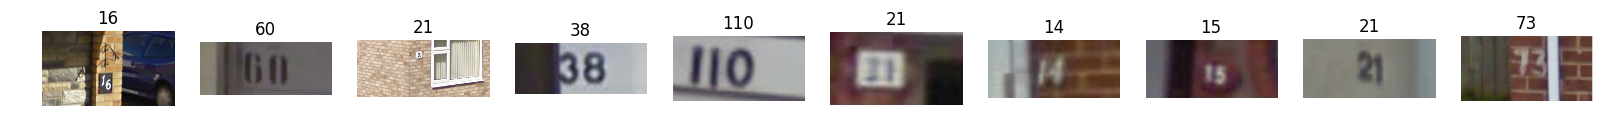

In [10]:
from PIL import Image
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
for i, item in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = test_filenames[item]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[item,0]):
        house_num += str(test_labels[item,k+1])
        
    im_samples.extend([item])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)